# RT2 Assignment2 

## Assignment 2 github link : 
 https://github.com/AmaniGhm/RT_Assignment2_Amani_Ghomrani-.git
 
The user can interact with the robot without needing the action_client_node.py file for setting/Canceling the robot Goal

### Steps to running the project : 

1 - run the notbook : 
            jupyter notebook --allow-root --ip 0.0.0.0
            
2 - launch the ROS project : 
            roslaunch assignment_2_2023 assignment1.launch 
            
3 - Run the notebook cells (using the shift + enter)

The tragectory window should open along with the buttons to send the goal and to cancel it.

In [1]:
import rospy
import actionlib
from assignment_2_2023.msg import PlanningAction, PlanningGoal, RobotState
from assignment_2_2023.srv import Getlasttarget
from nav_msgs.msg import Odometry
import ipywidgets as widgets
from IPython.display import display
import jupyros as jr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

# ROS node , Action client , Publisher

In [3]:
# Initialize the ROS node
rospy.init_node('jupyter_interface_node', anonymous=True)

# Action client
action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
action_client.wait_for_server()

# Publisher 
robot_state_pub = rospy.Publisher('/robot_state', RobotState, queue_size=10)


# Functions

In [4]:
# Initialize variables to store robot state
robot_x, robot_y = [], []  # Robot tragectery 
reached_x, reached_y = [], []  # Reached targets
canceled_x, canceled_y = None , None  # Canceled targets

# Initialize the global variables
goal_status = None
canceled = False
goal_x, goal_y = None , None

# Function to send a goal to the action server
def send_goal(x, y):
    global goal_x, goal_y
    goal_x = x
    goal_y = y
    goal = PlanningGoal()
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    action_client.send_goal(goal, done_cb=goal_done_callback)

def cancel_goal():
    action_client.cancel_goal()
    
# Function to get the last target
def get_last_target():
    response = get_last_target_service()
    print(f"Last target: x={response.target_x}, y={response.target_y}")

# Callback function for Goal reach status
def goal_done_callback(status, result):
    global goal_status
    goal_status = status

# Define button click functions
def on_send_button_clicked(b):
    send_goal(x_goal.value, y_goal.value)
    

def on_cancel_button_clicked(b):
    global canceled
    cancel_goal()
    canceled = True
            
# Function to process /odom message and publish robot state
def odom_callback(odom_msg):
    global canceled_x , canceled_y , canceled
    x = odom_msg.pose.pose.position.x
    y = odom_msg.pose.pose.position.y
    vel_x = odom_msg.twist.twist.linear.x
    vel_z = odom_msg.twist.twist.angular.z

    robot_state_msg = RobotState()
    robot_state_msg.x = x
    robot_state_msg.y = y
    robot_state_msg.vel_x = vel_x
    robot_state_msg.vel_z = vel_z
    # Update current robot position
    if canceled is True :
        canceled_x = x
        canceled_y = y
        canceled = False
    
    # Update the robot tragectory
    robot_x.append(x)
    robot_y.append(y)
    # Publish the message
    robot_state_pub.publish(robot_state_msg)
    
# Function to initialize the plot
def plot_init():
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    legend = plt.legend(handles, labels, loc='upper left')
    legend.set_title('Legend')
    return line, goal_marker

# Function to update the plot
def update_plot(frame):
    global goal_status, canceled_x, canceled_y
    
    line.set_data(robot_x, robot_y)
    
    if goal_status == actionlib.GoalStatus.SUCCEEDED:
        reached_marker.set_data([goal_x], [goal_y])
    elif goal_status == actionlib.GoalStatus.PREEMPTED:
        canceled_marker.set_data([canceled_x], [canceled_y])

    if goal_x is not None and goal_y is not None:
        goal_marker.set_data([goal_x], [goal_y])
    
    return line, goal_marker

# Subscribers
rospy.Subscriber('/odom', Odometry, odom_callback)

# WIDGETS : Buttons and plot

<IPython.core.display.Javascript object>


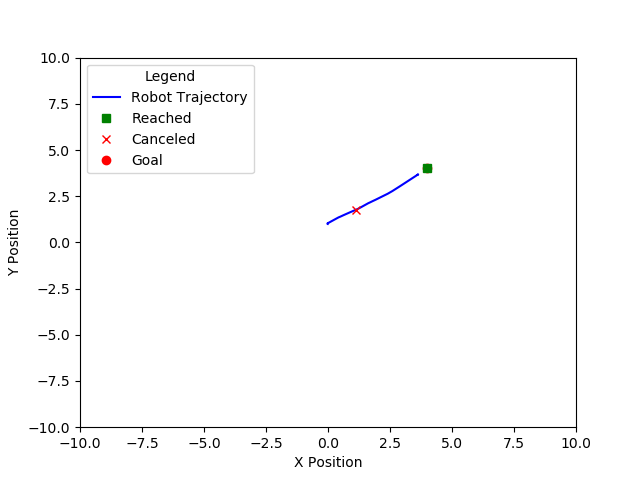

FloatText(value=0.0, description='X Goal:')

FloatText(value=0.0, description='Y Goal:')

Button(button_style='success', description='Send Goal', icon='check', style=ButtonStyle(), tooltip='Click to s…

Button(button_style='warning', description='Cancel Goal', icon='times', style=ButtonStyle(), tooltip='Click to…

Button(button_style='info', description='Get Last Target', icon='search', style=ButtonStyle(), tooltip='Click …

In [6]:
# Define Widgets
x_goal = widgets.FloatText(
    value=0.0, description='X Goal:', disabled=False
)

y_goal = widgets.FloatText(
    value=0.0, description='Y Goal:', disabled=False
)

send_button = widgets.Button(
    description='Send Goal', disabled=False, button_style='success', tooltip='Click to send goal', icon='check'
)

cancel_button = widgets.Button(
    description='Cancel Goal', disabled=False, button_style='warning', tooltip='Click to cancel goal', icon='times'
)

# Click event handlers to buttons
send_button.on_click(on_send_button_clicked)
cancel_button.on_click(on_cancel_button_clicked)

# Tragectory settings
%matplotlib notebook
fig, ax = plt.subplots()
line, = ax.plot([], [], 'b-', label='Trajectory')

# Markers
goal_marker, = ax.plot([], [], 'ro', label='Goal')
reached_marker, = ax.plot([], [], 'gs', label='Reached')
canceled_marker, = ax.plot([], [], 'rx', label='Canceled')

# Legend elements
handles = [
    Line2D([], [], color='blue', label='Robot Trajectory', linestyle='-'),
    Line2D([], [], marker='s', markersize=6, color='green', markerfacecolor='green', linestyle='None', label='Reached'),
    Line2D([], [], marker='x', markersize=6, color='red', markerfacecolor='red', linestyle='None', label='Canceled'),
    Line2D([], [], marker='o', markersize=6, color='red', markerfacecolor='red', linestyle='None', label='Goal'),
]

labels = [handle.get_label() for handle in handles]

# Display widgets
display(x_goal, y_goal, send_button, cancel_button, get_last_button)

# Function to handle the animation
ani = FuncAnimation(fig, update_plot, init_func=plot_init, blit=True, interval=100)
plt.show()